In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mglearn

#pacote que permite a interpolção de pontos
from scipy import interpolate

#implementa melhorias de visualização (opcional)
import seaborn as sns
sns.set()

In [2]:
#aumenta a fonte padrão de todos os labels nos gráficos daqui para frente
plt.rc('axes', labelsize= 14)    
plt.rc('xtick', labelsize=14)   
plt.rc('ytick', labelsize=14)    
plt.rc('legend', fontsize=14) 

In [3]:
#arquivo csv com todas as decisões assinaladas como "Direito Penal" ou "Direito Processual Penal"
data = pd.read_csv('data_criminal')
print('Número de documentos assinaladas como "Direito Penal" ou "Direito Processual Penal: ', len(data))

#arquivo csv com metadados dos documentos acima (data, ano, decisão monogrática e ramo do Direito)
meta = pd.read_csv('metadata_criminal')

#arquivo csv com metadados de todos os documentos que citam alguma Súmula Vinculante, independente do ramo do Direito
meta_bp = pd.read_csv('metadata.csv')

Número de documentos assinaladas como "Direito Penal" ou "Direito Processual Penal:  151765


In [4]:
#metadados das decisões anteriores a criação da SV 26
meta_menor_2009 = meta[meta['year'] < 2009]

#metadados das decisões posteriores a criação da SV 26
meta_maior_2009 = meta[meta['year'] >= 2009]

In [5]:
#cria em 'titles' lista de todos os documentos que citam a SV 26
titles = []
bps = list(meta_bp['bp'])
list_names = meta_bp['doc_id']
for i, bp in enumerate(bps):
    if '26' in bp:
        titles.append(list_names[i])
print('Número total de documentos que citam a SV 26: ', len(titles))

Número total de documentos que citam a SV 26:  954


In [6]:
#cria em 'titles' lista de todos os documentos que citam a SV 26
titles = []
bps = list(meta_bp['bp'])
list_names = meta_bp['doc_id']
for i, bp in enumerate(bps):
    if '26' in bp:
        titles.append(list_names[i])
print('Número total de documentos que citam a SV 26: ', len(titles))

Número total de documentos que citam a SV 26:  954


In [7]:
#seleciona os textos marcados como "Direito Penal" ou "Direito Processual Penal" que citam a SV 26
texts_26 = data[data['title'].isin(titles)]
meta_26 = meta[meta['title'].isin(titles)]
print('Número total de documentos de "Direito Penal" ou "Direito Processual Penal" que citam a SV 26: ', len(texts_26))

Número total de documentos de "Direito Penal" ou "Direito Processual Penal" que citam a SV 26:  565


In [8]:
#seleciona os textos marcados como "Direito Penal" ou "Direito Processual Penal" que *não* citam a SV 26
texts_n_26 = data[~data['title'].isin(titles)]
print('Número total de documentos de "Direito Penal" ou "Direito Processual Penal" que não citam a SV 26: ', len(texts_n_26))

Número total de documentos de "Direito Penal" ou "Direito Processual Penal" que não citam a SV 26:  151200


In [9]:
#cria uma lista de todos os meses de 2004 a 2018, ignorando apenas o dia específico
monht_list = []
for date in meta_26['date']:
    monht_list.append(date.split('-')[1] + '-' + date.split('-')[0])
meta_26['month'] = monht_list

<ipython-input-9-3c123e4e11b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_26['month'] = monht_list


In [10]:
month_list_af = ['0'+str(month) + '-' + str(year) if len(str(month)) == 1 else str(month) + '-' + str(year) for year in range(2010,2019) for month in range(1,13)]

In [11]:
cits_month = []
for month in month_list_af:
    cits_month.append(len(meta_26[meta_26['month'] == month]))

In [12]:
def moving_avarage_builder(citations_month, month_list):
    moving_av = [0 for i in range(3)]
    for i in range(3, len(citations_month)-3):
        moving_av.append(np.mean(citations_month[i-3:i+3]))
    moving_av.append(np.mean(citations_month[-6:]))
    moving_av.append(np.mean(citations_month[-6:]))
    moving_av.append(np.mean(citations_month[-6:]))
    return moving_av

In [13]:
int_data = moving_avarage_builder(cits_month, month_list_af)
tck = interpolate.splrep(range(len(month_list_af)), int_data, s=0)
xfit = np.linspace(0, len(month_list_af), 100)
yfit = interpolate.splev(xfit, tck, der=0)

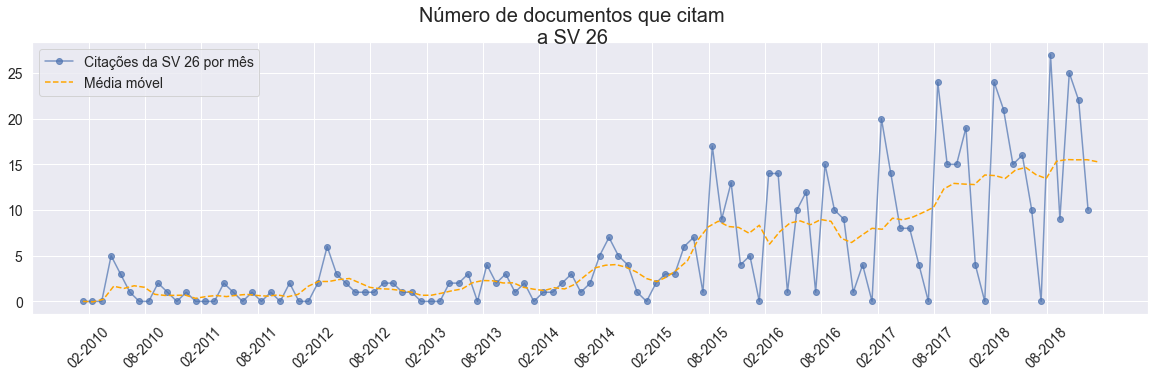

In [14]:
fig, ax = plt.subplots(figsize = (20, 5))
plt.suptitle('Número de documentos que citam\na SV 26', fontsize = 20)


ax.plot(month_list_af, cits_month,'-o' ,label = 'Citações da SV 26 por mês', alpha = 0.7)
ax.plot(xfit, yfit, '--', c= 'orange', label = 'Média móvel')
    
start, end = ax.get_xlim()
ax.tick_params(axis='x', rotation=45)
ax.set_xticks(np.arange(start, end, 6))
ax.legend()

plt.savefig('series_cit_mes.png', bbox_inches = 'tight')
plt.show()

# Seção 3.1

# Seção 3.2

In [15]:
#útil para a manipulação de strings, em especial, para retirar pontuação
import string

#versão em Sci-kit learn de "bag-of-words"
from sklearn.feature_extraction.text import CountVectorizer 

#versão em Sci-kit learn de TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#importa algoritmo para validação cruzada
from sklearn.model_selection import cross_val_score

#importa algoritmo de escolha de melhor modelo
from sklearn.model_selection import GridSearchCV

#importa pipeline para utilização sequencial vetorização + modelo
from sklearn.pipeline import make_pipeline

#importa regressão logística
from sklearn.linear_model import LogisticRegression

#utiliza a mesma seed para ter resultados iguais sempre que rodar o notebook
seed = 0
import random 
random.seed(seed)

#importa as stop words em português, isto é, palavras a ser ignoradas pelo vetorizador
from nltk.corpus import stopwords
pt_stp_words = stopwords.words('portuguese')

#pacote geral de estatística
import scipy.stats as stats

In [16]:
#modificação da função .tools.visualize_coefficients de mglearn para português
#https://github.com/amueller/mglearn/tree/master/mglearn

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['r' if c < 0 else 'b'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Magnitude do coeficiente", fontsize = 13)
    plt.xlabel("Palavra", fontsize = 13)
    plt.savefig('coefs.png')

In [17]:
X1 = list(texts_26['raw_text'])

#faz uma lista de índices dos documentos que não citam a SV 26
indexes_n_26 = list(range(0, len(texts_n_26)))

#escolhe uma amostra de mesmo tamanho de documentos que não citam a SV 26
indexes_X0 = random.sample(indexes_n_26, len(X1))
X0 = list(texts_n_26.iloc[indexes_X0]['raw_text'])

#escolhe uma amostra três vezes maior de documentos que não citam a SV 26 para fazer ensemble, sendo assim
#de mesmo tamanho cada componente do ensemble
indexes_X0_ensemble = random.sample(indexes_n_26, 3*len(X1))
X0_ensemble = list(texts_n_26.iloc[indexes_X0_ensemble]['raw_text'])

print('Tamnho X1: ', len(X1))
print('Tamnho X0: ', len(X0))
print('Tamnho X0_ensemble: ', len(X0_ensemble))

Tamnho X1:  565
Tamnho X0:  565
Tamnho X0_ensemble:  1695


In [18]:
def masker(dataset, list_of_masked):
    '''Mascara as palavras dos textos em 'dataset' presente em 'list_of_masked' por uma string vazia
    Input:  dataset = dataset de textos; list_of_masked = lista de palavras para mascarar
    Output: o mesmo dataset de texto, mas com palavras mascaradas'''
    masked_set = []
    for index in range(len(dataset)):
        new_string = ''
        
        #separa o documento em uma lista sequencial de palavras 
        #coloca a string em letra minúscula e tira a pontuação
        splitted_doc = dataset[index].lower().translate(str.maketrans('', '', string.punctuation)).split()
        for word in range(len(splitted_doc)):
            if splitted_doc[word].strip() in list_of_masked:
                new_string += ''
            else:
                new_string += ' '+ splitted_doc[word]
        masked_set.append(new_string)
    return masked_set

In [19]:
#lista de palavras para mascarar
words_to_mask = ['sv','s.v.', 's.v', 'sv.',
                 'súmula', 'vinculante', 'VINCULANTE', 'vin', 'vinc.', 'sumula', 'sum']

In [20]:
#como os números não devem ser fatores importantes na detetminação de possível citação da SV, mascaramos eles 
#também
def numeric_masker(dataset):
    '''Mascara os números inteiros dos textos em 'dataset'
    Input: dataset = dataset de textos
    Output: o mesmo dataset de texto, mas com números mascarados'''
    masked_set = []
    for index in range(len(dataset)):
        new_string = ''
        for word in range(len(dataset[index])):
            if dataset[index][word].isnumeric()==False:
                new_string += dataset[index][word]
            else:
                new_string += ''
        masked_set.append(new_string)
    return masked_set

In [21]:
X1 = numeric_masker(masker(X1, words_to_mask))
X0 = numeric_masker(masker(X0, words_to_mask))
X0_ensemble = numeric_masker(masker(X0_ensemble, words_to_mask))

KeyboardInterrupt: 

In [ ]:
X = X0 + X1
#faz a lista de classes
y = [0 for i in range(len(X0))] + [1 for i in range(len(X1))]

#modelo com bag-of-words e regressão logística
modelo_log_bag = make_pipeline(CountVectorizer(stop_words = pt_stp_words), LogisticRegression())
#procura o melhor hiperparâmetro C para a regressão logística
param_grid_log = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
#realiza a procura do parâmetro com validação cruzada de 5-folds
grid_log_bag = GridSearchCV(modelo_log_bag, param_grid_log, cv = 5)
grid_log_bag.fit(X, y)

#modelo com TF IDF e regressão logística
modelo_log_tf = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
#realiza a procura do parâmetro com validação cruzada de 5-folds
grid_log_tf = GridSearchCV(modelo_log_tf, param_grid_log, cv = 5)
grid_log_tf.fit(X, y)

In [ ]:
X_1 = X0_ensemble[:len(X1)] + X1
X_2 = X0_ensemble[len(X1):2*len(X1)] + X1
X_3 = X0_ensemble[2*len(X1):] + X1

#modelo com TF IDF e regressão logística com esnemble
modelo_log_tf_ens_1 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words + words_to_mask), LogisticRegression())
grid_log_tf_1 = GridSearchCV(modelo_log_tf_ens_1, param_grid_log, cv = 5)
grid_log_tf_1.fit(X_1, y)

modelo_log_tf_ens_2 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words + words_to_mask), LogisticRegression())
grid_log_tf_2 = GridSearchCV(modelo_log_tf_ens_2, param_grid_log, cv = 5)
grid_log_tf_2.fit(X_2, y)

modelo_log_tf_ens_3 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words + words_to_mask), LogisticRegression())
grid_log_tf_3 = GridSearchCV(modelo_log_tf_ens_3, param_grid_log, cv = 5)
grid_log_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para bag-of-words e regressão logística: {:.2f}".format(grid_log_bag.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística: {:.2f}".format(grid_log_tf.best_score_))

print("\n\n\nMelhor erro de validação cruzada para TF IDF e regressão logística, ensemble 1: {:.2f}".format(grid_log_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 2: {:.2f}".format(grid_log_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 3: {:.2f}".format(grid_log_tf_3.best_score_))

In [ ]:
#transforma as palavras em vetores
vectorizer = grid_log_bag.best_estimator_.named_steps["countvectorizer"]
X_train = vectorizer.transform(X)

# acha as palavras que mais têm impacto no modelo
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

#faz o plot de barras
visualize_coefficients(grid_log_bag.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features= 20)
plt.savefig('coefs.png')

In [ ]:
#checa a plotagem acima com o código original
mglearn.tools.visualize_coefficients(
grid_log_bag.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features= 20)

In [ ]:
#agora faremos os mesmos cálculos com os melhores parâmetros estimados no último passo
vectorizer_1 = TfidfVectorizer(stop_words = pt_stp_words)
X_1 = vectorizer_1.fit_transform(X_1)

vectorizer_2 = TfidfVectorizer(stop_words = pt_stp_words)
X_2 = vectorizer_2.fit_transform(X_2)

vectorizer_3 = TfidfVectorizer(stop_words = pt_stp_words)
X_3 = vectorizer_3.fit_transform(X_3)

In [ ]:
#transforma todos os textos em vetores pelos modelos de TF IDF criados pelo vocabulário de treinamento de cada
#componente do ensemble
corpus_1 = vectorizer_1.transform(list(data['raw_text']))
corpus_2 = vectorizer_2.transform(list(data['raw_text']))
corpus_3 = vectorizer_3.transform(list(data['raw_text']))

In [ ]:
#transforma todos os textos em vetores pelos modelos de TF IDF criados pelo vocabulário de treinamento de cada
#componente do ensemble
corpus_1 = vectorizer_1.transform(list(data['raw_text']))
corpus_2 = vectorizer_2.transform(list(data['raw_text']))
corpus_3 = vectorizer_3.transform(list(data['raw_text']))

In [ ]:
#performa as três regressões logísticas de ensemble com os melhores parâmetros
log1 = LogisticRegression(C = grid_log_tf_1.best_params_['logisticregression__C']).fit(X_1, y)
log2 = LogisticRegression(C = grid_log_tf_2.best_params_['logisticregression__C']).fit(X_2, y)
log3 = LogisticRegression(C = grid_log_tf_3.best_params_['logisticregression__C']).fit(X_3, y)

In [ ]:
prob_log_1 =  log1.predict_proba(corpus_1)
prob_log_2 =  log2.predict_proba(corpus_2)
prob_log_3 =  log3.predict_proba(corpus_3)

In [ ]:
prob_log = (prob_log_1[:,1] + prob_log_2[:,1] + prob_log_3[:,1])/3

In [ ]:
prob_log = (prob_log_1[:,1] + prob_log_2[:,1] + prob_log_3[:,1])/3

In [ ]:
titles_all = list(data['title'])
date = list(meta['date'])
year = list(meta['year'])

d = {'title': titles_all, 'date':date, 'year':year, 'log': prob_log}
predictions = pd.DataFrame(data = d)

In [ ]:
data[data['title'].isin(list(predictions[predictions['log'] > 0.5]['title']))].to_csv('before_sv.csv')

In [ ]:
def citations_per_year(threshdold):
    numb_count = []
    prop_count = []
    
    for year in list(range(2004, 2019)):
        numb_count.append(len(predictions[(predictions['log'] > threshdold) & (predictions['year'] == year)]))
        prop_count.append(len(predictions[(predictions['log'] > threshdold) & (predictions['year'] == year)])/len(predictions[predictions['year']== year]))
    
    return numb_count, prop_count

In [ ]:
fig, axs = plt.subplots(2, figsize = (20, 10))
plt.suptitle('Previsões por regressão logística', fontsize = 20)

for threshold in [0.5, 0.7, 0.8, 0.9, 0.95]:
    numb_count, prop_count = citations_per_year(threshold)
    axs[0].plot(list(range(2004, 2019)), numb_count, '-o', label = 'Limiar = ' + str(threshold))
    axs[1].plot(list(range(2004, 2019)), prop_count, '-o', label = 'Limiar = ' + str(threshold))

axs[0].axvline(2009, linestyle = '--', label = 'Criação da SV 26', c = 'blue')
axs[0].legend(fontsize = 13, loc="upper left")
axs[0].set_ylabel('Número de documentos', fontsize = 13)

axs[1].axvline(2009, linestyle = '--', label = 'Criação da SV 26', c = 'blue')
axs[1].legend(fontsize = 13, loc="upper left")
axs[1].set_ylabel('Proporção de documentos', fontsize = 13)

plt.savefig('series_models.png', bbox_inches = 'tight')
plt.show()

In [ ]:
log_count = citations_per_year(0.5)

In [ ]:
#escolhe apenas os documentos depois que 2004
predictions_2004 = predictions[predictions['year'] >= 2004]
predictions_2004

In [ ]:
#cria uma lista de todos os meses de 2004 a 2018, ignorando apenas o dia específico
monht_list = []
for date in predictions_2004['date']:
    monht_list.append(date.split('-')[1] + '-' + date.split('-')[0])
predictions_2004['month'] = monht_list

In [ ]:
#cria a lista de todos os meses entre 2004 e 2018 (não podemos fazer por set pois a ordem correta não seria mantida, mesmo se transformar em lista e usarmos sort)
#e entre os meses antes e depois da criação da SV
month_list_full = ['0'+str(month) + '-' + str(year) if len(str(month)) == 1 else str(month) + '-' + str(year) for year in range(2004,2019) for month in range(1,13)]
month_list_bf = ['0'+str(month) + '-' + str(year) if len(str(month)) == 1 else str(month) + '-' + str(year) for year in range(2004,2010) for month in range(1,13)]
month_list_af = ['0'+str(month) + '-' + str(year) if len(str(month)) == 1 else str(month) + '-' + str(year) for year in range(2010,2019) for month in range(1,13)]

In [ ]:
def citations_per_month(threshdold, dataset, month_list):
    numb_count = []
    prop_count = []
        
    for month in month_list:
        numb_count.append(len(dataset[(dataset['log'] > threshdold) & (dataset['month'] == month)]))
        
        if len(dataset[dataset['month'] == month]) != 0:
            prop_count.append(len(dataset[(dataset['log'] > threshdold) & (dataset['month'] == month)])/len(dataset[dataset['month'] == month]))
        else:
            prop_count.append(prop_count[-1])
    return numb_count, prop_count

In [ ]:
numb_count,_ = citations_per_month(0.5, predictions_2004, month_list_full)
int_data = moving_avarage_builder(numb_count, month_list_full)

In [ ]:
tck = interpolate.splrep(range(len(month_list_full)), int_data, s=0)

In [ ]:
xfit = np.linspace(0, len(month_list_full), 90)
yfit = interpolate.splev(xfit, tck, der=0)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
plt.suptitle('Previsões por regressão logística', fontsize = 20)


ax.plot(month_list_full, numb_count,'-o' ,label = 'Previsões com limiar em 0.5', alpha = 0.7)
ax.plot(xfit, yfit, '--', c= 'orange', label = 'Média móvel')
    
start, end = ax.get_xlim()
ax.tick_params(axis='x', rotation=45)
ax.set_xticks(np.arange(start, end, 6))
ax.axvline('12-2009', linestyle = '--', label = 'Criação da SV 26', c = 'blue', alpha  = 0.5)
ax.legend(loc = 'upper left')

plt.savefig('series_models_mes.png', bbox_inches = 'tight')
plt.show()

In [ ]:
predictions_bf_sv = predictions_2004[predictions_2004['year'] < 2010]
predictions_af_sv = predictions_2004[predictions_2004['year'] >= 2010]

# Seção 3.3

In [2]:
#importa PCA
from sklearn.decomposition import PCA

#importa normlizador Z
from sklearn.preprocessing import StandardScaler

#importa classificador por Support Vector Machines (SVM)
from sklearn.svm import SVC

#importa classificador random forest
from sklearn.ensemble import RandomForestClassifier

#importa Naive Bayes
from sklearn.naive_bayes import MultinomialNB

#importa tensorflow para redes neurais
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [3]:
#importa dados anotados com 'mérito' ou 'processual'
texts_26_anot = pd.read_csv('annotated_texts.csv')
texts_26_anot = texts_26_anot[['text', 'class']]

#escolhe como classe '0' os documentos que citam e utilizam apenas de forma processual
X0_proc = list(texts_26_anot[texts_26_anot['class'] == 0]['text'])
#escolhe como classe '1' os documentos que citam e tratam de mérito
X1 = list(texts_26_anot[texts_26_anot['class'] == 1]['text'])

#vamos ver o tamanho de cada uma dessas classes
print(len(X0_proc), len(X1))

220 251


## Regressão logística com dataset reduzido

In [ ]:
random.seed(1)
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)))
X0_outros1 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X_1 =  random.sample(X1, int(len(X1)/2)) + random.sample(X0_proc, int(len(X1)/2)) + X0_outros1
X_1 = numeric_masker(masker(X_1, words_to_mask))

random.seed(11)
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)))
X0_outros2 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X_2 =  random.sample(X1, int(len(X1)/2)) + random.sample(X0_proc, int(len(X1)/2)) + X0_outros2
X_2 = numeric_masker(masker(X_2, words_to_mask))

random.seed(111)
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)))
X0_outros3 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X_3 =  random.sample(X1, int(len(X1)/2)) + random.sample(X0_proc, int(len(X1)/2)) + X0_outros3
X_3 = numeric_masker(masker(X_3, words_to_mask))


y = [0 for i in range(2*int(len(X1)/2))] + [1 for i in range(len(X1))]

In [ ]:
param_grid_log = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

#modelo com TF IDF e regressão logística com esnemble
modelo_log_tf_ens_1 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_1 = GridSearchCV(modelo_log_tf_ens_1, param_grid_log, cv = 5)
grid_log_tf_1.fit(X_1, y)

modelo_log_tf_ens_2 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_2 = GridSearchCV(modelo_log_tf_ens_2, param_grid_log, cv = 5)
grid_log_tf_2.fit(X_2, y)

modelo_log_tf_ens_3 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_3 = GridSearchCV(modelo_log_tf_ens_3, param_grid_log, cv = 5)
grid_log_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 1: {:.2f}".format(grid_log_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 2: {:.2f}".format(grid_log_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 3: {:.2f}".format(grid_log_tf_3.best_score_))

## Diferenciação entre mérito e processual

In [ ]:
random.seed(1)
X0_proc1 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros1 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_1 = X0_proc1 + X0_outros1
X_1 = X0_1 + X1
X_1 = numeric_masker(masker(X_1, words_to_mask))

random.seed(11)
X0_proc2 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros2 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_2 = X0_proc2 + X0_outros2
X_2 = X0_2 + X1
X_2 = numeric_masker(masker(X_2, words_to_mask))


random.seed(111)
X0_proc3 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros3 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_3 = X0_proc3 + X0_outros3
X_3 = X0_3 + X1
X_3 = numeric_masker(masker(X_3, words_to_mask))


y = [0 for i in range(len(X0_3))] + [1 for i in range(len(X1))]

### Regressão logística

In [ ]:
param_grid_log = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

#modelo com TF IDF e regressão logística com esnemble
modelo_log_tf_ens_1 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_1 = GridSearchCV(modelo_log_tf_ens_1, param_grid_log, cv = 5)
grid_log_tf_1.fit(X_1, y)

modelo_log_tf_ens_2 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_2 = GridSearchCV(modelo_log_tf_ens_2, param_grid_log, cv = 5)
grid_log_tf_2.fit(X_2, y)

modelo_log_tf_ens_3 = make_pipeline(TfidfVectorizer(stop_words = pt_stp_words), LogisticRegression())
grid_log_tf_3 = GridSearchCV(modelo_log_tf_ens_3, param_grid_log, cv = 5)
grid_log_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 1: {:.2f}".format(grid_log_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 2: {:.2f}".format(grid_log_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e regressão logística, ensemble 3: {:.2f}".format(grid_log_tf_3.best_score_))

In [ ]:
#transforma as palavras em vetores
vectorizer = grid_log_tf_3.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(X_3)

# acha as palavras que mais têm impacto no modelo
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

#faz o plot de barras
visualize_coefficients(grid_log_tf_3.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features= 20)
plt.savefig('coef_ann.png')

In [ ]:
#agora faremos os mesmos cálculos com os melhores parâmetros estimados no último passo
vectorizer_1 = TfidfVectorizer(stop_words = pt_stp_words)
X_1 = vectorizer_1.fit_transform(X_1)

vectorizer_2 = TfidfVectorizer(stop_words = pt_stp_words)
X_2 = vectorizer_2.fit_transform(X_2)

vectorizer_3 = TfidfVectorizer(stop_words = pt_stp_words)
X_3 = vectorizer_3.fit_transform(X_3)

In [ ]:
#performa, para fins de visualização, PCA no dataset
pca = PCA(n_components = 2)
pca.fit(X_1.toarray())
X_1pca = pca.transform(X_1.toarray())

y_pca = [0 for i in range(len(X0_proc1))] + [1 for i in range(len(X0_outros1))] + [2 for i in range(len(X1))]
plt.scatter(X_1pca[:,0][:len(X0_proc1)], X_1pca[:,1][:len(X0_proc1)], label = 'Documentos que citam a\n SV 26 de forma processual')
plt.scatter(X_1pca[:,0][len(X0_proc1)+len(X0_outros1):], X_1pca[:,1][len(X0_proc1)+len(X0_outros1):], label = 'Documentos que citam a\n SV 26 em mérito')
plt.scatter(X_1pca[:,0][len(X0_proc1):len(X0_proc1)+len(X0_outros1)], X_1pca[:,1][len(X0_proc1):len(X0_proc1)+len(X0_outros1)], label = 'Documentos que não\n citam a SV 26')
plt.legend(bbox_to_anchor=(0.75, 1.05))
plt.savefig('scatter.png',  bbox_inches = 'tight')
plt.show()

In [ ]:
#transforma todos os textos em vetores pelos modelos de TF IDF criados pelo vocabulário de treinamento de cada
#componente do ensemble
corpus_1 = vectorizer_1.transform(list(data['raw_text']))
corpus_2 = vectorizer_2.transform(list(data['raw_text']))
corpus_3 = vectorizer_3.transform(list(data['raw_text']))

In [ ]:
#performa as três regressões logísticas de ensemble com os melhores parâmetros
log1 = LogisticRegression(C = grid_log_tf_1.best_params_['logisticregression__C']).fit(X_1, y)
log2 = LogisticRegression(C = grid_log_tf_2.best_params_['logisticregression__C']).fit(X_2, y)
log3 = LogisticRegression(C = grid_log_tf_3.best_params_['logisticregression__C']).fit(X_3, y)

In [ ]:
prob_log_1 =  log1.predict_proba(corpus_1)
prob_log_2 =  log2.predict_proba(corpus_2)
prob_log_3 =  log3.predict_proba(corpus_3)

In [ ]:
prob_log = (prob_log_1[:,1] + prob_log_2[:,1] + prob_log_3[:,1])/3

In [ ]:
titles_all = list(data['title'])
date = list(meta['date'])
year = list(meta['year'])

d = {'title': titles_all, 'date':date, 'year':year, 'log': prob_log}
predictions = pd.DataFrame(data = d)

In [ ]:
predictions

In [ ]:
fig, axs = plt.subplots(figsize = (20, 10))

for threshold in [0.5, 0.7, 0.8, 0.9, 0.95]:
    log_count,_ = citations_per_year(threshold)
    axs.plot(list(range(2004, 2019)), log_count, '-o', label = 'Limiar = ' + str(threshold))
axs.axvline(2009, linestyle = '--', label = 'Criação da SV 26', c = 'blue')
axs.legend(fontsize = 13, loc="upper left")
axs.set_title('Regressão logística', fontsize = 17)
axs.set_ylabel('Proporção de documentos', fontsize = 13)


plt.savefig('series_models_annot.png')
plt.show()

### SVC com kernel RGB

In [ ]:
#modelo com TF IDF e SVC com esnemble
param_grid_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10]}

modelo_svm_tf_ens_1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_1 = GridSearchCV(modelo_svm_tf_ens_1, param_grid_svm, cv = 5)
#precismamos usar to array aqui porque o escalador não funciona para matrizes
#esparsas
grid_svm_tf_1.fit(X_1.toarray(), y)

modelo_svm_tf_ens_2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_2 = GridSearchCV(modelo_svm_tf_ens_2, param_grid_svm, cv = 5)
grid_svm_tf_2.fit(X_2.toarray(), y)

modelo_svm_tf_ens_3 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_3 = GridSearchCV(modelo_svm_tf_ens_3, param_grid_svm, cv = 5)
grid_svm_tf_3.fit(X_3.toarray(), y)

In [ ]:
print("Melhor erro de validação cruzada para TF IDF e SVM com kernel RGB, ensemble 1: {:.2f}".format(grid_svm_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e SVM com kernel RGB, ensemble 2: {:.2f}".format(grid_svm_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e SVM com kernel RGB, ensemble 3: {:.2f}".format(grid_svm_tf_3.best_score_))

### Random forest

In [ ]:
param_grid_rf = {'randomforestclassifier__n_estimators': [1, 10, 100, 1000, 10000]}

#modelo com TF IDF e random forest com esnemble
modelo_rf_tf_ens_1 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_1 = GridSearchCV(modelo_rf_tf_ens_1, param_grid_rf, cv = 5)
grid_rf_tf_1.fit(X_1, y)

modelo_rf_tf_ens_2 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_2 = GridSearchCV(modelo_rf_tf_ens_2, param_grid_rf, cv = 5)
grid_rf_tf_2.fit(X_2, y)

modelo_rf_tf_ens_3 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_3 = GridSearchCV(modelo_rf_tf_ens_3, param_grid_rf, cv = 5)
grid_rf_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para TF IDF e random forest, ensemble 1: {:.2f}".format(grid_rf_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e random forest, ensemble 2: {:.2f}".format(grid_rf_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e random forest, ensemble 3: {:.2f}".format(grid_rf_tf_3.best_score_))

### Naive Bayes

In [ ]:
param_grid_nb = {'multinomialnb__alpha': [0, 0.5, 1]}

#modelo com TF IDF e naive bayes com esnemble
modelo_nb_tf_ens_1 = make_pipeline(MultinomialNB())
grid_nb_tf_1 = GridSearchCV(modelo_nb_tf_ens_1, param_grid_nb, cv = 5)
grid_nb_tf_1.fit(X_1, y)

modelo_nb_tf_ens_2 = make_pipeline(MultinomialNB())
grid_nb_tf_2 = GridSearchCV(modelo_nb_tf_ens_2, param_grid_nb, cv = 5)
grid_nb_tf_2.fit(X_2, y)

modelo_nb_tf_ens_3 = make_pipeline(MultinomialNB())
grid_nb_tf_3 = GridSearchCV(modelo_nb_tf_ens_3, param_grid_nb, cv = 5)
grid_nb_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para TF IDF e Naive Bayes, ensemble 1: {:.2f}".format(grid_nb_tf_1.best_score_))
print("Melhor erro de validação cruzada para TF IDF e Naive Bayes, ensemble 2: {:.2f}".format(grid_nb_tf_2.best_score_))
print("Melhor erro de validação cruzada para TF IDF e Naive Bayes, ensemble 3: {:.2f}".format(grid_nb_tf_3.best_score_))

## Embeddings por Universal Sentence Encoder

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
random.seed(1)
X0_proc1 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros1 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_1 = X0_proc1 + X0_outros1
X_1 = X0_1 + X1
X_1 = numeric_masker(masker(X_1, words_to_mask))

random.seed(11)
X0_proc2 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros2 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_2 = X0_proc2 + X0_outros2
X_2 = X0_2 + X1
X_2 = numeric_masker(masker(X_2, words_to_mask))


random.seed(111)
X0_proc3 = random.sample(X0_proc, int(len(X1)/2))
indexes_X0_outros = random.sample(indexes_n_26, int(len(X1)/2))
X0_outros3 = list(texts_n_26.iloc[indexes_X0_outros]['raw_text'])
X0_3 = X0_proc3 + X0_outros3
X_3 = X0_3 + X1
X_3 = numeric_masker(masker(X_3, words_to_mask))


y = [0 for i in range(len(X0_3))] + [1 for i in range(len(X1))]

In [ ]:
X_1 = use(X_1)

In [ ]:
X_2 = use(X_2)

In [ ]:
X_3 = use(X_3)

In [ ]:
X_1 = [tensor.numpy() for tensor in X_1]
X_2 = [tensor.numpy() for tensor in X_2]
X_3 = [tensor.numpy() for tensor in X_3]

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X_1)
X_1pca = pca.transform(X_1)

y_pca = [0 for i in range(len(X0_proc1))] + [1 for i in range(len(X0_outros1))] + [2 for i in range(len(X1))]
plt.scatter(X_1pca[:,0][:len(X0_proc1)], X_1pca[:,1][:len(X0_proc1)], label = 'Documentos que citam a\n SV 26 de forma processual')
plt.scatter(X_1pca[:,0][len(X0_proc1)+len(X0_outros1):], X_1pca[:,1][len(X0_proc1)+len(X0_outros1):], label = 'Documentos que citam a\n SV 26 em mérito')
plt.scatter(X_1pca[:,0][len(X0_proc1):len(X0_proc1)+len(X0_outros1)], X_1pca[:,1][len(X0_proc1):len(X0_proc1)+len(X0_outros1)], label = 'Documentos que não\n citam a SV 26')
plt.legend(bbox_to_anchor=(0.75, 0.25))
plt.savefig('scatter_use.png',  bbox_inches = 'tight')
plt.show()

### Regressão logística

In [ ]:
param_grid_log = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

#modelo com TF IDF e regressão logística com esnemble
modelo_log_tf_ens_1 = make_pipeline(LogisticRegression())
grid_log_tf_1 = GridSearchCV(modelo_log_tf_ens_1, param_grid_log, cv = 5)
grid_log_tf_1.fit(X_1, y)

modelo_log_tf_ens_2 = make_pipeline(LogisticRegression())
grid_log_tf_2 = GridSearchCV(modelo_log_tf_ens_2, param_grid_log, cv = 5)
grid_log_tf_2.fit(X_2, y)

modelo_log_tf_ens_3 = make_pipeline(LogisticRegression())
grid_log_tf_3 = GridSearchCV(modelo_log_tf_ens_3, param_grid_log, cv = 5)
grid_log_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para USE e regressão logística, ensemble 1: {:.2f}".format(grid_log_tf_1.best_score_))
print("Melhor erro de validação cruzada para USE e regressão logística, ensemble 2: {:.2f}".format(grid_log_tf_2.best_score_))
print("Melhor erro de validação cruzada para USE e regressão logística, ensemble 3: {:.2f}".format(grid_log_tf_3.best_score_))

### SVM com kernel RGB

In [ ]:
#modelo com TF IDF e SVC com esnemble
param_grid_svm = {'svc__C': [0.001, 0.01, 0.1, 1, 10]}

modelo_svm_tf_ens_1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_1 = GridSearchCV(modelo_svm_tf_ens_1, param_grid_svm, cv = 5)
#precismamos usar to array aqui porque o escalador não funciona para matrizes
#esparsas
grid_svm_tf_1.fit(X_1, y)

modelo_svm_tf_ens_2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_2 = GridSearchCV(modelo_svm_tf_ens_2, param_grid_svm, cv = 5)
grid_svm_tf_2.fit(X_2, y)

modelo_svm_tf_ens_3 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
grid_svm_tf_3 = GridSearchCV(modelo_svm_tf_ens_3, param_grid_svm, cv = 5)
grid_svm_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para USE e SVM com kernel RGB, ensemble 1: {:.2f}".format(grid_svm_tf_1.best_score_))
print("Melhor erro de validação cruzada para USE e SVM com kernel RGB, ensemble 2: {:.2f}".format(grid_svm_tf_2.best_score_))
print("Melhor erro de validação cruzada para USE e SVM com kernel RGB, ensemble 3: {:.2f}".format(grid_svm_tf_3.best_score_))

### Random forest

In [ ]:
param_grid_rf = {'randomforestclassifier__n_estimators': [1, 10, 100, 1000, 10000]}

#modelo com TF IDF e random forest com esnemble
modelo_rf_tf_ens_1 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_1 = GridSearchCV(modelo_rf_tf_ens_1, param_grid_rf, cv = 5)
grid_rf_tf_1.fit(X_1, y)

modelo_rf_tf_ens_2 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_2 = GridSearchCV(modelo_rf_tf_ens_2, param_grid_rf, cv = 5)
grid_rf_tf_2.fit(X_2, y)

modelo_rf_tf_ens_3 = make_pipeline(RandomForestClassifier(random_state = 0))
grid_rf_tf_3 = GridSearchCV(modelo_rf_tf_ens_3, param_grid_rf, cv = 5)
grid_rf_tf_3.fit(X_3, y)

In [ ]:
print("Melhor erro de validação cruzada para USE e random forest, ensemble 1: {:.2f}".format(grid_rf_tf_1.best_score_))
print("Melhor erro de validação cruzada para USE e random forest, ensemble 2: {:.2f}".format(grid_rf_tf_2.best_score_))
print("Melhor erro de validação cruzada para USE e random forest, ensemble 3: {:.2f}".format(grid_rf_tf_3.best_score_))